## Method
- Normalize prediction risk maps (0, 1)
- Get max, average and max_by_cell prediction risk map based on risk matrix obtained from different DB (experiment_10_2_SEPPexp...)
- Transform cell prediction to be on range (0, 255)
- Compute texture measures based on GLCM ( gray-level co-occurrence matrix)

## Hypothesis:
Entropy is higher on maps generated from a multimodal approximation; additionally, compared to unimodal approximations, multimodal maps are more heterogeneous, with lower energy and higher contrast.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform
import pickle
import open_cp
import gentex

In [2]:
from services import prediction_metrics
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

Failed to import `rtree`.
Failed to import `rtree`.


## Built-in

In [3]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

In [4]:
def normalize_grid_prediction(row, column_name):
    xoffset = row[column_name]._xoffset
    yoffset = row[column_name]._yoffset
    xsize = row[column_name]._xsize
    ysize = row[column_name]._ysize
    matrix_norm = row[column_name]._matrix.copy()
    # Uses 1 division and matix.size multiplications, multiplication is faster than division
    matrix_norm *= 1/row[column_name]._matrix.max()
    return open_cp.predictors.GridPredictionArray(xsize=xsize,ysize=ysize,matrix=matrix_norm,xoffset=xoffset,yoffset=yoffset)
    

In [5]:
def to_gray_scale(matrix):
    matrix_int = (matrix.copy() * 254).astype(int)
    #matrix_offset = np.ones([matrix.shape[0],matrix.shape[1]]) # to avoid elements with 0 value (measures as entropy can be computed)
    return (matrix_int).astype(int)

### Fusion operators

In [6]:
def average_grid_prediction(row):
    xoffset_avg = (row['prediction_siedco']._xoffset + row['prediction_rnmc']._xoffset + row['prediction_nuse']._xoffset)/3
    yoffset_avg = (row['prediction_siedco']._yoffset + row['prediction_rnmc']._yoffset + row['prediction_nuse']._yoffset)/3
    xsize_avg = (row['prediction_siedco']._xsize + row['prediction_rnmc']._xsize + row['prediction_nuse']._xsize)/3
    ysize_avg = (row['prediction_siedco']._ysize + row['prediction_rnmc']._ysize + row['prediction_nuse']._ysize)/3
    matrix_avg = (row['prediction_siedco']._matrix + row['prediction_rnmc']._matrix + row['prediction_nuse']._matrix)/3
    return open_cp.predictors.GridPredictionArray(xsize=xsize_avg,ysize=ysize_avg,matrix=matrix_avg,xoffset=xoffset_avg,yoffset=yoffset_avg)

In [7]:
import operator

def maximum_grid_prediction(row):
    max_intensity = {}
    max_intensity['siedco']=np.sum(row['prediction_siedco']._matrix)
    max_intensity['rnmc']=np.sum(row['prediction_rnmc']._matrix)
    max_intensity['nuse']=np.sum(row['prediction_nuse']._matrix)
    key_max_intensity = max(max_intensity.items(), key=operator.itemgetter(1))[0]
    
    column = 'prediction_'+str(key_max_intensity)
    xoffset_max = row[column]._xoffset
    yoffset_max = row[column]._yoffset
    xsize_max = row[column]._xsize
    ysize_max = row[column]._ysize
    matrix_max = row[column]._matrix
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_max,xoffset=xoffset_max,yoffset=yoffset_max)


In [8]:
def maximum_by_cell(row):
    matrix_1 = np.maximum(row['prediction_siedco']._matrix, row['prediction_rnmc']._matrix)
    matrix_2 = np.maximum(matrix_1, row['prediction_nuse']._matrix)
    # assign any from DB, since all attributes are equal
    xoffset_max = row['prediction_siedco']._xoffset
    yoffset_max = row['prediction_siedco']._yoffset
    xsize_max = row['prediction_siedco']._xsize
    ysize_max = row['prediction_siedco']._ysize
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_2,xoffset=xoffset_max,yoffset=yoffset_max)

### Texture features

In [9]:
def shannon_entropy(matrix):
    my_array = np.squeeze(np.asarray(matrix))
    # ignore zero values for successful compute of log in entropy eq.
    # https://stats.stackexchange.com/questions/57069/alternative-to-shannons-entropy-when-probability-equal-to-zero
    non_zero_array = my_array[my_array != 0]
    p_normalized = non_zero_array / non_zero_array.sum()
    entropy = -np.sum(p_normalized*np.log2(p_normalized))
    return entropy

In [10]:
from scipy.stats import entropy
import math

def scipy_entropy(matrix, base):
    my_array = np.squeeze(np.asarray(matrix))
    non_zero_array = my_array[my_array != 0]
    return entropy(pk=non_zero_array, base=base)

In [11]:
import gentex
texm = ['CM Entropy',
        'EM Entropy',
        'Statistical Complexity',
        'Energy Uniformity',
        'Maximum Probability',
        'Contrast',
        'Inverse Difference Moment',
        'Correlation',
        'Homogeneity',
        'Multifractal Spectrum Energy Range',
        'Multifractal Spectrum Entropy Range']

def gclm_text(current_prediction,feature):
    matrix = to_gray_scale(current_prediction._matrix)
    mask = np.ones([matrix.shape[0],matrix.shape[1]])
    d = 1 # 1 cell-distance
    offset = [[1*d,0],[-1*d,0],[0,1*d],[0,-1*d],[1*d,1*d],[-1*d,-1*d],[1*d,-1*d],[-1*d,1*d]] #all diections
    cm = gentex.comat.comat_mult(matrix, mask, offset, levels=255)
    mytex = gentex.texmeas.Texmeas(comat=cm, coordmom=2, probmom=1)
    mytex.calc_measure(feature)
    return abs(mytex.val)

## Load prediction results

In [12]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

In [13]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_rnmc_prediction.pkl','rb')
loaded_rnmc = pickle.load(infile)
infile.close()

In [14]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_nuse_prediction.pkl','rb')
loaded_nuse = pickle.load(infile)
infile.close()

## Normalize prediction intensity risk maps

In [15]:
loaded_siedco['prediction_normalized'] = loaded_siedco.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_rnmc['prediction_normalized'] = loaded_rnmc.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_nuse['prediction_normalized'] = loaded_nuse.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)


In [16]:
# Delete not-normalized prediction columns
loaded_siedco.drop(columns=['prediction'], inplace=True)
loaded_rnmc.drop(columns=['prediction'], inplace=True)
loaded_nuse.drop(columns=['prediction'], inplace=True)

### Rename columns to merge df

In [17]:
loaded_siedco = loaded_siedco.rename(columns={'prediction_normalized': 'prediction_siedco', 'eval_pts': 'eval_pts_siedco','initial-date':'initial-date-siedco','final-date':'final-date-siedco'})
loaded_rnmc = loaded_rnmc.rename(columns={'prediction_normalized': 'prediction_rnmc', 'eval_pts': 'eval_pts_rnmc', 'initial-date':'initial-date-rnmc','final-date':'final-date-rnmc'})
loaded_nuse = loaded_nuse.rename(columns={'prediction_normalized': 'prediction_nuse', 'eval_pts': 'eval_pts_nuse', 'initial-date':'initial-date-nuse','final-date':'final-date-nuse'})

## Compute maximum and average prediction

In [18]:
result = pd.concat([loaded_siedco, loaded_rnmc, loaded_nuse], axis=1)

In [19]:
result['average_prediction'] = result.apply(lambda row: average_grid_prediction(row), axis=1)

In [20]:
result['max_prediction'] = result.apply(lambda row: maximum_grid_prediction(row), axis=1)

In [21]:
result['max_cell_prediction'] = result.apply(lambda row: maximum_by_cell(row), axis=1)

### Delete redundant columns

In [22]:
result.drop(columns=['initial-date-rnmc','final-date-rnmc','initial-date-nuse','final-date-nuse'], inplace=True)

In [23]:
result = result.rename(columns={'initial-date-siedco':'initial-date','final-date-siedco':'final-date'})

## Risk maps

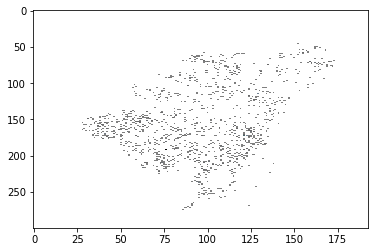

In [79]:
from matplotlib.colors import LinearSegmentedColormap

a = result['prediction_siedco'].values[0]._matrix
custom_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#ffffff'),
                                              (0.01, '#D3D3D3'),
                                              (0.02, '#C0C0C0'),
                                              (0.03, '#A9A9A9'),
                                              (0.05, '#808080'),
                                              (0.1, '#696969'),
                                              (0.3, '#778899'),
                                              (0.5, '#708090'),
                                              (0.8, '#2F4F4F'),
                                              (1,    '#000000')], N=256)
b=a[::-1]
plt.imshow(b[:300,150:], cmap=custom_cmap, aspect='auto')
file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
plt.savefig(file_path+'siedco_map.svg',dpi=300,bbox_inches = "tight")
plt.show()

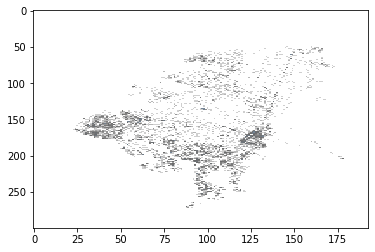

In [80]:
a = result['prediction_rnmc'].values[0]._matrix
custom_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#ffffff'),
                                              (0.01, '#D3D3D3'),
                                              (0.02, '#C0C0C0'),
                                              (0.03, '#A9A9A9'),
                                              (0.05, '#808080'),
                                              (0.1, '#696969'),
                                              (0.3, '#778899'),
                                              (0.5, '#708090'),
                                              (0.8, '#2F4F4F'),
                                              (1,    '#000000')], N=256)
b=a[::-1]
plt.imshow(b[:300,150:], cmap=custom_cmap, aspect='auto')
file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
plt.savefig(file_path+'rnmc_map.svg',dpi=300,bbox_inches = "tight")
plt.show()

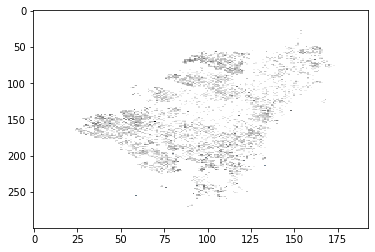

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

a = result['prediction_nuse'].values[0]._matrix
custom_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#ffffff'),
                                              (0.01, '#D3D3D3'),
                                              (0.02, '#C0C0C0'),
                                              (0.03, '#A9A9A9'),
                                              (0.05, '#808080'),
                                              (0.1, '#696969'),
                                              (0.3, '#778899'),
                                              (0.5, '#708090'),
                                              (0.8, '#2F4F4F'),
                                              (1,    '#000000')], N=256)
b=a[::-1]
plt.imshow(b[:300,150:], cmap=custom_cmap, aspect='auto')
file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
plt.savefig(file_path+'nuse_map.svg',dpi=300,bbox_inches = "tight")
plt.show()

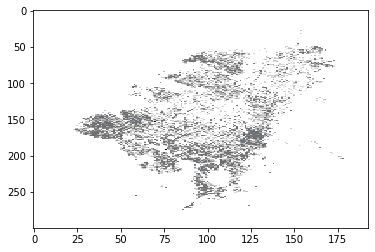

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

a = result['average_prediction'].values[0]._matrix
custom_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#ffffff'),
                                              (0.01, '#D3D3D3'),
                                              (0.02, '#C0C0C0'),
                                              (0.03, '#A9A9A9'),
                                              (0.05, '#808080'),
                                              (0.1, '#696969'),
                                              (0.3, '#778899'),
                                              (0.5, '#708090'),
                                              (0.8, '#2F4F4F'),
                                              (1,    '#000000')], N=256)
b=a[::-1]
plt.imshow(b[:300,150:], cmap=custom_cmap, aspect='auto')
file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
plt.savefig(file_path+'average_fusion_map.svg',dpi=300,bbox_inches = "tight")
plt.show()

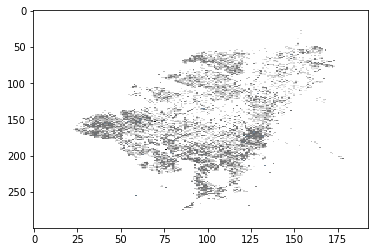

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

a = result['max_cell_prediction'].values[0]._matrix
custom_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#ffffff'),
                                              (0.01, '#D3D3D3'),
                                              (0.02, '#C0C0C0'),
                                              (0.03, '#A9A9A9'),
                                              (0.05, '#808080'),
                                              (0.1, '#696969'),
                                              (0.3, '#778899'),
                                              (0.5, '#708090'),
                                              (0.8, '#2F4F4F'),
                                              (1,    '#000000')], N=256)
b=a[::-1]
plt.imshow(b[:300,150:], cmap=custom_cmap, aspect='auto')
file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
plt.savefig(file_path+'max_fusion_map.svg',dpi=300,bbox_inches = "tight")
plt.show()

## Compute texture features

In [35]:
df_result = result.copy()

### 1. CM Entropy

In [36]:
feature = 'CM Entropy'
short_name = 'CM_entropy'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


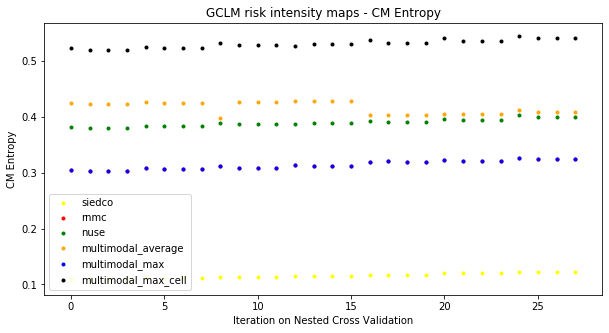

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

### 2. Statistical Complexity

In [38]:
feature = 'Statistical Complexity'
short_name = 'stat_complex'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


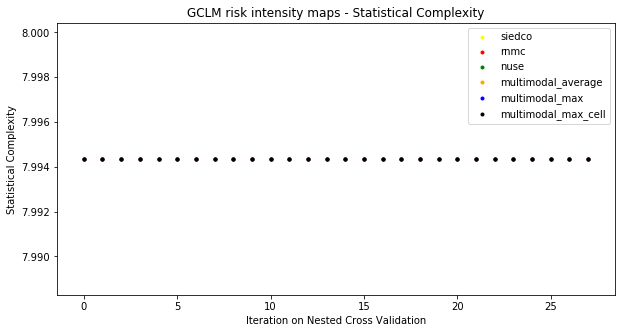

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

### 3. Energy Uniformity

In [40]:
feature = 'Energy Uniformity'
short_name = 'energy_unif'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


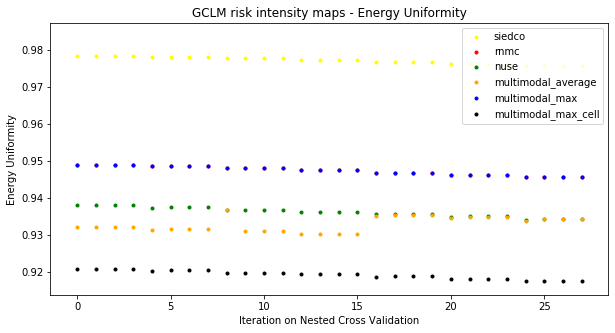

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

### 4. Maximum Probability

In [42]:
feature = 'Maximum Probability'
short_name = 'max_prob'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


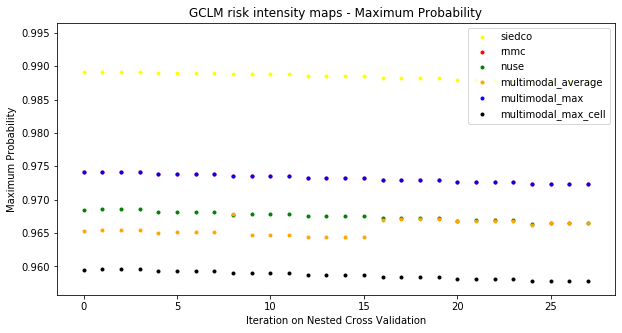

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

### 5. Contrast

In [44]:
feature = 'Contrast'
short_name = 'contrast'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


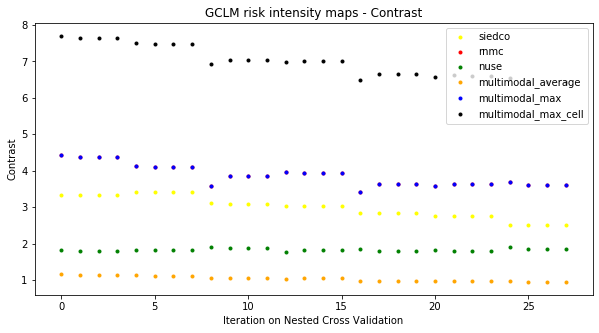

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

### 6. Inverse Difference Moment

In [46]:
feature = 'Inverse Difference Moment'
short_name = 'inv_dif_mom'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


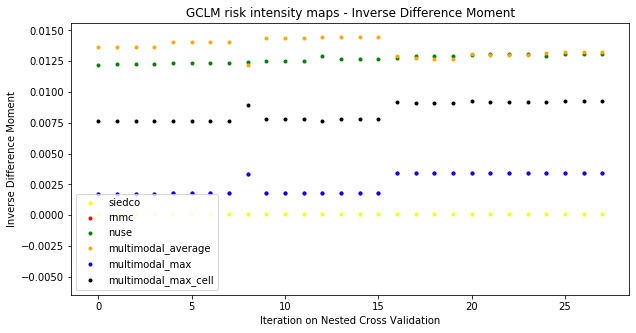

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

### 7. Correlation

In [48]:
feature = 'Correlation'
short_name = 'correlation'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


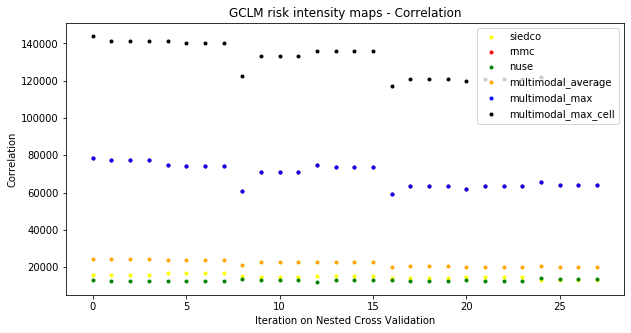

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

### 8. Homogeneity

In [50]:
feature = 'Homogeneity'
short_name = 'homogen'
df_result[str('siedco_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_siedco'],feature), axis=1)
df_result[str('rnmc_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_rnmc'],feature), axis=1)
df_result[str('nuse_'+short_name)] = df_result.apply(lambda row: gclm_text(row['prediction_nuse'],feature), axis=1)
df_result[str('multi_average_'+short_name)] = df_result.apply(lambda row: gclm_text(row['average_prediction'],feature), axis=1)
df_result[str('multi_max_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_prediction'],feature), axis=1)
df_result[str('multi_maxcell_'+short_name)] = df_result.apply(lambda row: gclm_text(row['max_cell_prediction'],feature), axis=1)


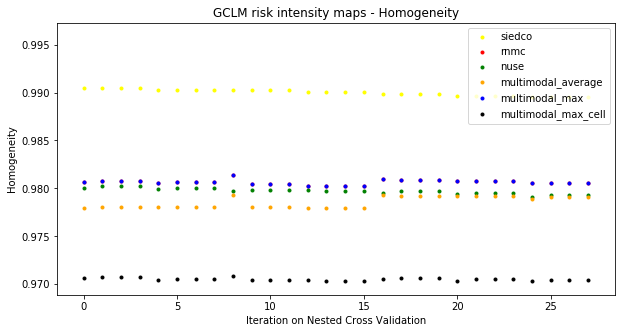

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(df_result.index.values,df_result[str('siedco_'+short_name)].values, marker=".",color='yellow')
rnmc = ax.scatter(df_result.index.values,df_result[str('rnmc_'+short_name)].values, marker=".",color='red')
nuse = ax.scatter(df_result.index.values,df_result[str('nuse_'+short_name)].values, marker=".",color='green')
multimodal_average = ax.scatter(df_result.index.values,df_result[str('multi_average_'+short_name)].values, marker=".",color='orange')
multimodal_max = ax.scatter(df_result.index.values,df_result[str('multi_max_'+short_name)].values, marker=".",color='blue')
multimodal_max_cell = ax.scatter(df_result.index.values,df_result[str('multi_maxcell_'+short_name)].values, marker=".",color='black')
ax.set_title(str('GCLM risk intensity maps - '+feature))
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max, multimodal_max_cell),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max', 'multimodal_max_cell'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel(feature)
plt.show()

In [52]:
print(df_result.mean())

siedco_CM_entropy                  0.115347
rnmc_CM_entropy                    0.313797
nuse_CM_entropy                    0.389167
multi_average_CM_entropy           0.415887
multi_max_CM_entropy               0.313797
multi_maxcell_CM_entropy           0.530179
siedco_stat_complex                7.994353
rnmc_stat_complex                  7.994353
nuse_stat_complex                  7.994353
multi_average_stat_complex         7.994353
multi_max_stat_complex             7.994353
multi_maxcell_stat_complex         7.994353
siedco_energy_unif                 0.977098
rnmc_energy_unif                   0.947344
nuse_energy_unif                   0.936134
multi_average_energy_unif          0.932889
multi_max_energy_unif              0.947344
multi_maxcell_energy_unif          0.919165
siedco_max_prob                    0.988461
rnmc_max_prob                      0.973280
nuse_max_prob                      0.967517
multi_average_max_prob             0.965834
multi_max_max_prob              

## Texture features comparison

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
def compute_width(value, max_value, max_width):
    current_width = round(value*max_width/max_value)
    if current_width > 20:
        return current_width
    else:
        return 20

In [3]:

theta=[36,108,180,252,324]
theta=[36,99,162,225,318]
labels = ['Unimodal: legal complaints','Unimodal: police penalties','Unimodal: emergency calls','Multimodal: average-fusion','Multimodal: max-fusion']

In [ ]:
entropy_values=[0.12,0.31,0.39,0.42,0.53]
width= list(map(lambda x: compute_width(x,max(entropy_values),30), entropy_values))

fig = go.Figure(go.Barpolar())

for i in list(range(5)):
    
    fig.add_trace(go.Barpolar(
        r=[entropy_values[i]],
        theta=[theta[i]],
        width=[width[i]],
        marker_color=[px.colors.qualitative.Plotly[i]],
        marker_line_color="black",
        marker_line_width=2,
        opacity=0.8,
        name = labels[i]
    ))        

fig.update_layout(
    template=None,
    title = "Entropy",
    polar = dict(
        radialaxis = dict(range=[0,0.6], showticklabels=True, tickmode = 'linear', tick0 = 0, dtick = 0.2),
        angularaxis = dict(showticklabels=False, ticks='')
    ),
    legend_font_size=14,
    legend=dict(orientation="h",
                yanchor="bottom",
                y=-0.4,
                xanchor="center",
                x=1),
    showlegend = True
)
file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
fig.write_image(file_path+'GLCM_entropy.svg')
    
fig.show()

In [ ]:
homogeneity_values=[0.990,0.981,0.980,0.979,0.971]
width= list(map(lambda x: compute_width(x,max(homogeneity_values),30), homogeneity_values))

fig = go.Figure(go.Barpolar())

for i in list(range(5)):
    
    fig.add_trace(go.Barpolar(
        r=[homogeneity_values[i]],
        theta=[theta[i]],
        width=[width[i]],
        marker_color=[px.colors.qualitative.Plotly[i]],
        marker_line_color="black",
        marker_line_width=2,
        opacity=0.8,
        name = labels[i]
    ))        

fig.update_layout(
    template=None,
    title = "Homogeneity",
    polar = dict(
        radialaxis = dict(range=[0.96, 1.0], showticklabels=True, tickmode = 'linear', tick0 = 0.96, dtick = 0.01),
        angularaxis = dict(showticklabels=False, ticks='')
    ),
    legend_font_size=14,
    legend=dict(orientation="h",
                yanchor="bottom",
                y=-0.4,
                xanchor="center",
                x=1),
    showlegend = True
)

file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
fig.write_image(file_path+'GLCM_homogeneity.svg')
fig.show()

In [ ]:
energy_values=[0.98,0.95,0.94,0.93,0.92]
width= list(map(lambda x: compute_width(x,max(energy_values),30), energy_values))

fig = go.Figure(go.Barpolar())

for i in list(range(5)):
    
    fig.add_trace(go.Barpolar(
        r=[energy_values[i]],
        theta=[theta[i]],
        width=[width[i]],
        marker_color=[px.colors.qualitative.Plotly[i]],
        marker_line_color="black",
        marker_line_width=2,
        opacity=0.8,
        name = labels[i]
    ))        

fig.update_layout(
    template=None,
    title = "Energy",
    polar = dict(
        radialaxis = dict(range=[0.90, 0.99], showticklabels=True, tickmode = 'linear', tick0 = 0.90, dtick = 0.03),
        angularaxis = dict(showticklabels=False, ticks='')
    ),
    legend_font_size=14,
    legend=dict(orientation="h",
                yanchor="bottom",
                y=-0.4,
                xanchor="center",
                x=1),
    showlegend = True
)

file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
fig.write_image(file_path+'GLCM_energy.svg')
fig.show()

In [ ]:
contrast_values=[3,3.8,1.8,1,7]
width= list(map(lambda x: compute_width(x,max(contrast_values),30), contrast_values))

fig = go.Figure(go.Barpolar())

for i in list(range(5)):
    
    fig.add_trace(go.Barpolar(
        r=[contrast_values[i]],
        theta=[theta[i]],
        width=[width[i]],
        marker_color=[px.colors.qualitative.Plotly[i]],
        marker_line_color="black",
        marker_line_width=2,
        opacity=0.8,
        name = labels[i]
    ))        

fig.update_layout(
    template=None,
    title = "Contrast",
    polar = dict(
        radialaxis = dict(range=[0,8], showticklabels=True, tickmode = 'linear', tick0 = 0, dtick = 2),
        angularaxis = dict(showticklabels=False, ticks='')
    ),
    legend_font_size=14,
    legend=dict(orientation="h",
                yanchor="bottom",
                y=-0.4,
                xanchor="center",
                x=1),
    showlegend = True
)

file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
fig.write_image(file_path+'GLCM_contrast.svg')
fig.show()

In [ ]:
correlation_values=[15,69,13,22,120]
width= list(map(lambda x: compute_width(x,max(correlation_values),30), correlation_values))

fig = go.Figure(go.Barpolar())

for i in list(range(5)):
    
    fig.add_trace(go.Barpolar(
        r=[correlation_values[i]],
        theta=[theta[i]],
        width=[width[i]],
        marker_color=[px.colors.qualitative.Plotly[i]],
        marker_line_color="black",
        marker_line_width=2,
        opacity=0.8,
        name = labels[i]
    ))        

fig.update_layout(
    template=None,
    title = "Correlation",
    polar = dict(
        radialaxis = dict(range=[0,130], showticklabels=True, tickmode = 'linear', tick0 = 0, dtick = 30),
        angularaxis = dict(showticklabels=False, ticks='')
    ),
    legend_font_size=14,
    legend=dict(orientation="h",
                yanchor="bottom",
                y=-0.4,
                xanchor="center",
                x=1),
    showlegend = True
)

file_path = '/Users/anamaria/Desktop/multimodal prediction draft figures/'
fig.write_image(file_path+'GLCM_correlation.svg')
fig.show()